In [1]:
from dataloader import DAVIS_Seq2, normalize_image
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [2]:
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)

batch_size = 10
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [31]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

Text(0.5, 1.0, 'Curr Frame')

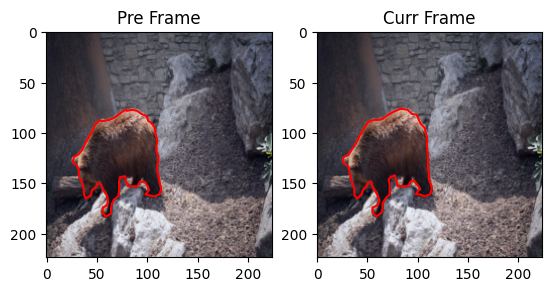

In [32]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [30]:
model = Model()

In [33]:
def chamer_distance_loss(x, y):
    def my_chamfer_distance(x, y):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = torch.sum((x - y) ** 2, dim=-1)
        dist1 = torch.min(dist, dim=1)[0]
        dist2 = torch.min(dist, dim=0)[0]
        return torch.mean(dist1) + torch.mean(dist2)
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

In [7]:
torch.cuda.empty_cache()

In [34]:
output = model(pre_frame, curr_frame, pre_boundary)
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(6.8944, grad_fn=<DivBackward0>)

In [4]:
model = Model().to('cuda')
data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
model_name = "uniform_model"
# data_set = DAVIS_Seq2(is_uniform=False, is_one_video=True)
# model_name = "simplify_model"
batch_size = 17
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [5]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

0.1630253791809082

In [6]:
dict_loss = {}
num_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=1e-4)
gradient_clip = 1
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for e in range(num_epochs):
    model.train()
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = chamer_distance_loss(predic_boundary, curr_boundary.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"{model_name}.pth")
    dict_loss[e] = loss.item()
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {loss.item()}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]


Epoch 1, Loss: 6.9571428298950195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.37s/it]


Epoch 2, Loss: 6.54642915725708


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


Epoch 3, Loss: 9.348631858825684


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.36s/it]


Epoch 4, Loss: 6.174074172973633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 5, Loss: 7.898971080780029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 6, Loss: 6.428539276123047


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


Epoch 7, Loss: 5.091076850891113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 8, Loss: 5.839846134185791


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 9, Loss: 6.3497633934021


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 10, Loss: 6.441476345062256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 11, Loss: 6.633930683135986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 12, Loss: 6.810878753662109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 13, Loss: 7.714310169219971


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


Epoch 14, Loss: 7.451799392700195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 15, Loss: 6.201448917388916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 16, Loss: 7.500977039337158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  4.00s/it]


Epoch 17, Loss: 8.675570487976074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 18, Loss: 6.002552509307861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.02s/it]


Epoch 19, Loss: 6.574349880218506


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 20, Loss: 6.0917067527771


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 21, Loss: 6.124797344207764


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 22, Loss: 6.294523239135742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  4.00s/it]


Epoch 23, Loss: 6.281992435455322


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 24, Loss: 8.487942695617676


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  4.00s/it]


Epoch 25, Loss: 7.360930442810059


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 26, Loss: 6.231626510620117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 27, Loss: 6.65730094909668


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.00s/it]


Epoch 28, Loss: 5.838317394256592


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


Epoch 29, Loss: 5.604135990142822


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]

Epoch 30, Loss: 6.163967132568359


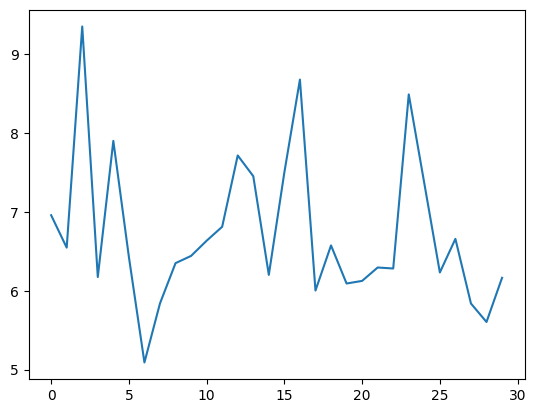

In [8]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [9]:
model = Model()
model_name = "uniform_model"
model.load_state_dict(torch.load(f"{model_name}.pth"))
model = model.to("cuda")

In [10]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

100%|███████████████████████████████████| 81/81 [00:02<00:00, 33.62it/s]


0.41037089008370436

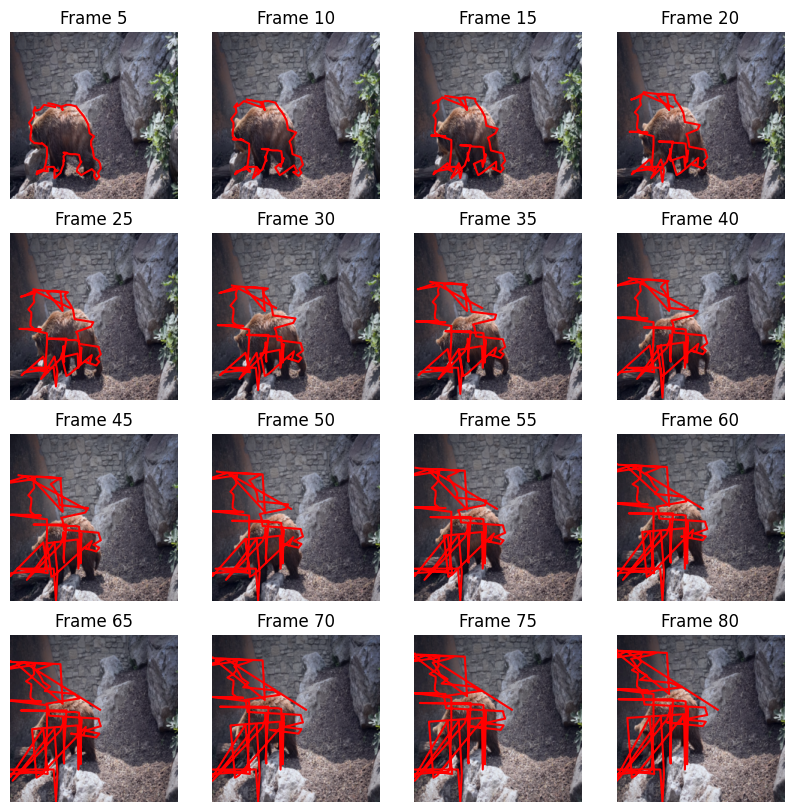

In [29]:
def test_model_one_video(model, test_dataset: DAVIS_test, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 5
    plt.figure(figsize=(10, 10))
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            pre_img = img
            if i % interval == 0:
                plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], 'r')
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
test_model_one_video(model, DAVIS_test("bear", is_uniform=True))